In [1]:
using Pkg
Pkg.activate("../")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using StatsBase, Distributions, Plots, LinearAlgebra, Plots

In [3]:
using Revise

includet("../src/ESGModels/msvar.jl")
includet("../src/ESGModels/msvar_gibs.jl")
includet("../src/ESGModels/msvar_simulate.jl") 

In [4]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [-.02 .4 .25; .045 .15 .43]
Σ2 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2]
Σ = [Σ1, Σ2]

transition_matrix = [.98 .02;.05 .95]

states_zero = [.3, .7]
X = [.12, .06]



n_steps = 500
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

500×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.112203   0.0447517
  0.103187   0.0559647
  0.166252   0.0895756
  0.286751   0.0533645
  0.345289   0.137481
  0.223902   0.143381
  0.0794063  0.129939
  0.143931   0.0977215
  0.180738   0.129741
  0.0527743  0.0817511
  ⋮          
  0.13196    0.140371
 -0.0102309  0.0893833
 -0.0254514  0.031076
  0.19826    0.0724424
  0.168683   0.0675277
  0.183301   0.104147
  0.298322   0.0750905
  0.131018   0.133028
  0.10253    0.115467

In [5]:
regime_count = count_regime_transitions(test_regimes, 2) 
regime_count ./ sum(regime_count, dims=2)

2×2 Matrix{Float64}:
 0.986637  0.013363
 0.12      0.88

In [6]:
display(count(x -> x==1, test_regimes))
unconditional_regimes(transition_matrix)

450

2-element Vector{Float64}:
 0.7142857142857144
 0.2857142857142857

In [7]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 2 #n_regimes
n_variables = 2
Β = [Β1, Β2]
Σ = [Σ1, Σ2]

2-element Vector{Matrix{Float64}}:
 [0.0064 0.0007199999999999999; 0.0007199999999999999 0.0009]
 [0.0324 0.002205; 0.002205 0.0012250000000000002]

In [8]:
r = 1
display("regime count")
display(count(x -> x==r, test_regimes)/n_steps)

Ym = filter_X(Y, test_regimes[2:end], r)
Xm = filter_X(X, test_regimes[2:end], r)
Beta_mean = inv(Xm' * Xm) * Xm' * Ym
display(Beta_mean') 

display("true beta")
display(Β[r])

"regime count"

0.9

2×3 adjoint(::Matrix{Float64}) with eltype Float64:
 0.0717395  0.316219  0.31772
 0.0353704  0.145744  0.507964

"true beta"

2×3 Matrix{Float64}:
 0.09  0.3  0.2
 0.03  0.1  0.6

In [9]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)
t_m = zeros(n, 2, 2)

states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
t_m[1, :, :] = sample_transition_matrix(states[1, :], k)

for s in 2:n
    states_zero = unconditional_regimes(t_m[s-1, :, :])
    states[s, :] = simulate_regimes(Y, X, Β, Σ, t_m[s-1, :, :], states_zero)
    t_m[s, :, :] = sample_transition_matrix(states[s, :], k)    
end 

r1 = [count(x -> x ==1, states[:,t]) for t in 1:n_steps-1] / n
display(r1)
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

499-element Vector{Float64}:
 0.994
 0.9938
 0.9894
 0.9866
 0.9928
 0.9944
 0.9956
 0.9966
 0.9948
 0.996
 ⋮
 0.9784
 0.9692
 0.9782
 0.9886
 0.996
 0.9942
 0.99
 0.9828
 0.9824

"transition matrix"

2×2 Matrix{Float64}:
 0.984502  0.0154976
 0.131284  0.868716

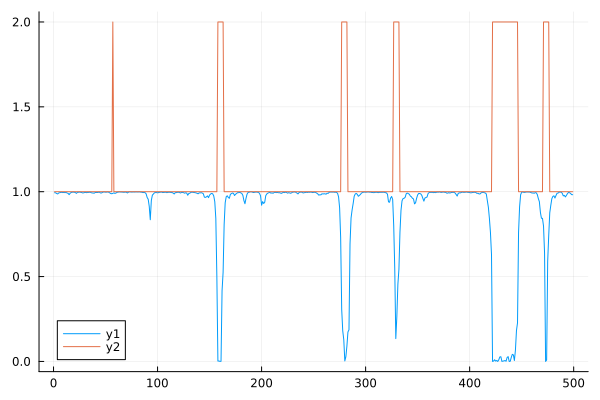

In [10]:
plot(r1)
plot!(test_regimes[2:end])

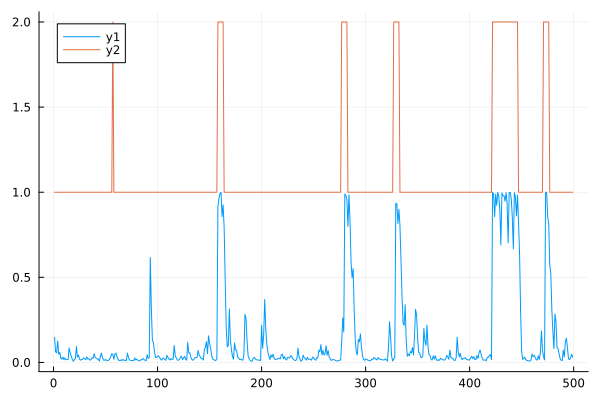

In [11]:
states_zero = [.6, .4]
regimes_probs = hamilton_filter(Y,X, Β, Σ, transition_matrix, states_zero)

plot(regimes_probs[:,2])
plot!(test_regimes[2:end])

In [12]:
n = 5_000
k= 2 #n regimes

states = zeros(Int64, n, T)


states_zero = unconditional_regimes(transition_matrix)
states[1, :] = simulate_regimes(Y, X, Β, [Σ1, Σ2], transition_matrix, states_zero)
cov_sample = [sample_covariance(Y, X, Β, states[1,:], k)] 

for s in 2:n
    states_zero = unconditional_regimes(transition_matrix)
    states[s, :] = simulate_regimes(Y, X, Β, Σ, transition_matrix, states_zero)
    push!(cov_sample, sample_covariance(Y, X, Β, states[s,:], k))    
end 

cov1_mean = mean(map(x -> x[1], cov_sample))
cov2_mean = mean(map(x -> x[2], cov_sample))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.07647399705848185
 0.03143103773035395

"regime two"

2-element Vector{Float64}:
 0.17024925334315166
 0.03709264527690496

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0      0.28117
 0.28117  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.502675
 0.502675  1.0

In [13]:
n_burn = 20_000
n_sample = 2000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, transition_matrix, [Β0', Β0'], [Σ0, Σ0], n_burn, n_sample)

([2 2 … 2 2; 2 2 … 2 2; … ; 2 2 … 2 2; 2 2 … 2 2], [0.8151207491484809 0.009985679689961622; 0.9159869189250943 0.014470663115549894; … ; 0.9074082618633719 0.01718211138240257; 0.7770691117555265 0.024745886833327305;;; 0.18487925085151907 0.9900143203100384; 0.08401308107490565 0.9855293368844501; … ; 0.0925917381366281 0.9828178886175973; 0.22293088824447357 0.9752541131666728], Vector{Any}[[[-0.04383752789794899 0.3226839775265315 0.3099485981720931; 0.04854482338387839 0.11200416149626204 0.2708599772903348], [0.06089292960104277 0.33725081084239833 0.3353206717876266; 0.03819351674092117 0.13756422405367896 0.4877279119041782]], [[-0.02770963264646331 0.48103673111698053 -0.3102523632180492; 0.0538553041324166 0.1770321243797524 0.16091383752944027], [0.07254499416964785 0.32418729596629137 0.3114427639275769; 0.03594128281659068 0.1508419879535826 0.505794544169094]], [[0.04212711003789718 0.5256104904553036 -0.6134781989317436; 0.05247678353235951 0.1609922740655757 0.229702725

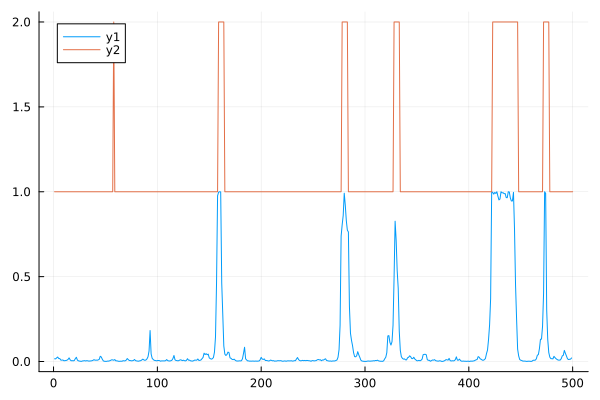

In [14]:
r1 = [count(x -> x ==1, regimes[:,t]) for t in 1:n_steps-1] / n_sample

plot(r1)
plot!(test_regimes)

In [15]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))



"transition matrix"

2×2 Matrix{Float64}:
 0.857155   0.142845
 0.0151982  0.984802

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 -0.00515468  0.402814  -0.0731452
  0.041124    0.114203   0.411155

"regime two"

2×3 Matrix{Float64}:
 0.073429   0.319648  0.30381
 0.0386853  0.141821  0.488915

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.1755874676286783
 0.036249430016602725

"regime two"

2-element Vector{Float64}:
 0.07653176057221213
 0.031316708601266854

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.518454
 0.518454  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0       0.283722
 0.283722  1.0

In [33]:
Β1 = [.09 .3 .2; .03 .1 .6]
Σ1 = cor2cov([1 .3; .3 1], [.08, .03])
Β2 = [.05 .35 .29; .06 .12 .5]
Σ2 = cor2cov([1 .4; .4 1], [.1, .04])
Β3 = [-.02 .4 .25; .045 .15 .43]
Σ3 = cor2cov([1 .35; .35 1], [.18, .035])

Β = [Β1, Β2, Β3]
Σ = [Σ1, Σ2, Σ3]

transition_matrix = [.90 .07 .03;.05 .85 .1;.13 .07 .80;]

states_zero = [.3, .1, .6]
X = [.12, .06]

n_steps = 1000
test_regimes = simulate_regimes(states_zero, transition_matrix, n_steps, 1)
test_returns = simulate_msvar_returns(test_regimes, Β, Σ, X, n_steps, 1)[:,:,1]'

1000×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.177244     0.0885787
  0.210874     0.133399
  0.0996453    0.141216
  0.142497     0.0962639
 -0.097221     0.102144
 -0.386368     0.0304287
 -0.250569     0.0240439
 -0.248919    -0.00719641
 -0.151262     0.0247995
 -0.374771     0.101266
  ⋮           
  0.292936     0.141963
  0.204075     0.152081
 -0.00958406   0.197937
 -0.0278039    0.164087
 -0.0447437    0.127471
  0.12062      0.193783
  0.30545      0.172917
  0.228616     0.113524
  0.185799     0.126243

In [34]:
count(x -> x==3, test_regimes)

232

In [35]:
Y = collect(test_returns[2:end,:])
T = n_steps-1
p = 1
X = hcat(ones(T), test_returns[p:end-1,:])
k= 3 #n_regimes
n_variables = 2


2

In [36]:
n_burn = 50_000
n_sample = 4000
n = 2
Β0 = (inv(transpose(X) * X) * transpose(X) * Y)
Σ0 = transpose((Y -  X * Β0)) * (Y -  X * Β0) / (T- n -1)
t_m0 = [.9 .05 .05; .05 .9 .05; .05 .05 .9]

tm0 = [.9 .1; .1 .9]

regimes, t_m, Β_post, Σ_post = msvar(Y, X, t_m0, [Β0', Β0', Β0'], [Σ0, Σ0, Σ0], n_burn, n_sample)

([3 2 … 3 3; 2 2 … 2 2; … ; 3 3 … 2 2; 3 3 … 2 2], [0.0 0.013160584575546185 5.914010115450371e-254; 0.0 0.007969755681825319 0.0; … ; 1.9102512652257207e-206 0.0031389408877566887 0.0; 0.0 0.007491195736825166 6.489106657661966e-239;;; 4.443885667374418e-158 0.9256244387052185 0.14537220965310685; 1.6485126431934128e-259 0.9042859104274835 0.12080696135343914; … ; 0.0 0.9020770309897334 0.19093006293525702; 6.264329062183001e-232 0.9141154829315337 0.2088526375063892;;; 1.0 0.061214976719235155 0.8546277903468932; 1.0 0.08774433389069128 0.8791930386465608; … ; 0.9999999999999999 0.09478402812250998 0.809069937064743; 1.0 0.0783933213316412 0.7911473624936108], Vector{Any}[[[-0.7825687974947277 -2.6260144743076808 8.86124426748089; 0.1386982212126004 -0.3129475349566604 0.40386091504613386], [0.10658756625796507 0.33444315164594507 -0.0019727598360344684; 0.03603055762916038 0.08657890436863333 0.6335991117860873], [0.0053046537972999235 0.4771220418595369 0.2614439073842023; 0.049159

In [28]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))
display("regime three")
display(mean(map(x -> x[3],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))
cov3_mean = mean(map(x -> x[3], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))
display("regime three")
display(sqrt.(diag(cov3_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))
display("regime three")
display(cov2cor(cov3_mean))

"transition matrix"

3×3 Matrix{Float64}:
 0.842881   0.157098     2.07621e-5
 0.0563463  0.934073     0.00958034
 0.999818   0.000114592  6.73929e-5

"coefficients"

"regime one"

2×3 Matrix{Float64}:
 0.00343053  0.403604  0.287821
 0.0512021   0.143399  0.42777

"regime two"

2×3 Matrix{Float64}:
 0.0816383  0.340694  0.203063
 0.0310696  0.110145  0.60754

"regime three"

2×3 Matrix{Float64}:
 -0.515072   -3.89175   10.5537
 -0.0612315  -0.610407   2.56472

"standard deviations"

"regime one"

2-element Vector{Float64}:
 0.1544103378790251
 0.038384422847044124

"regime two"

2-element Vector{Float64}:
 0.08719506921221153
 0.03236779292499512

"regime three"

2-element Vector{Float64}:
 5.402060374869631
 4.563799841112153

"correlations"

"regime one"

2×2 Matrix{Float64}:
 1.0       0.416112
 0.416112  1.0

"regime two"

2×2 Matrix{Float64}:
 1.0      0.32636
 0.32636  1.0

"regime three"

2×2 Matrix{Float64}:
  1.0       -0.609331
 -0.609331   1.0

In [ ]:
regimes, t_m, Β_post, Σ_post = regimes[1:4:end], t_m[1:4:end], Β_post[1:4:end], Σ_post[1:4:end]

500-element Vector{Vector{Any}}:
 [[0.02137042292101058 0.0019278471204107737; 0.0019278471204107737 0.0013653653591127201], [0.008125504950736044 0.0008132371471501966; 0.0008132371471501966 0.0011197942702622773], [0.14938146443883654 0.0201666094538959; 0.0201666094538959 0.004056595188856465]]
 [[0.017958336044572382 0.002352752297793332; 0.002352752297793332 0.0013893350527644725], [0.008171661724250956 0.0010288739401935292; 0.0010288739401935292 0.0012203093573588892], [0.8404150638818645 0.05357757649006127; 0.05357757649006127 0.005424757408890293]]
 [[0.025197446438619115 0.00229024628127918; 0.00229024628127918 0.001056491118916194], [0.008795131185738584 0.0009875651535189251; 0.0009875651535189251 0.0011769729491681508], [0.487501818185926 0.09843070257376242; 0.09843070257376242 0.02073334064356968]]
 [[0.024004851449094113 0.002291070585710158; 0.002291070585710158 0.0012498149849580107], [0.007910680696332453 0.001084256340944881; 0.001084256340944881 0.0011932138407221

In [ ]:
display("transition matrix")
display(mean(t_m, dims=1)[1,:,:])

display("coefficients")
display("regime one")
display(mean(map(x -> x[1],Β_post)))
display("regime two")
display(mean(map(x -> x[2],Β_post)))
display("regime three")
display(mean(map(x -> x[3],Β_post)))


cov1_mean = mean(map(x -> x[1], Σ_post))
cov2_mean = mean(map(x -> x[2], Σ_post))
cov3_mean = mean(map(x -> x[3], Σ_post))

display("standard deviations")
display("regime one")
display(sqrt.(diag(cov1_mean)))
display("regime two")
display(sqrt.(diag(cov2_mean)))
display("regime three")
display(sqrt.(diag(cov3_mean)))


display("correlations")
display("regime one")
display(cov2cor(cov1_mean))
display("regime two")
display(cov2cor(cov2_mean))
display("regime three")
display(cov2cor(cov3_mean))

In [21]:
using Test
regimes = [1 2 2 1 1 2 1]
n_regimes = 2
n_variables = 2 
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == true

regimes = [1 1 1 1 1 1 2]
n_regimes = 2
n_variables = 2 
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == false

regimes = [1 2 2 3 3 1 3]
n_regimes = 3
n_variables = 1
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == true

regimes = [1 2 2 1 1]
n_regimes = 3
n_variables = 1
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == false 

regimes = [1 2 2 3 3 1 3]
n_regimes = 3
n_variables = 2
result = evaluate_all_regimes_sampled(regimes, n_regimes, n_variables)
@test result == false

Test Failed at c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X26sZmlsZQ==.jl:6
  Expression: result == true
   Evaluated: false == true



Test.FallbackTestSetException: Test.FallbackTestSetException("There was an error during testing")

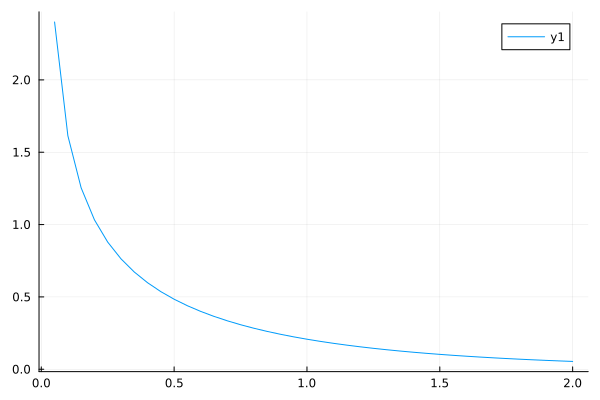

In [22]:
x = .05:.05:2
dist = [pdf(Gamma(0.5,1), r) for r in x]

plot(x, dist)